### INSIGHTS

In [2]:
import pandas as pd
import numpy as np

In [3]:
import spacy

In [4]:
nlp = spacy.load('pt_core_news_lg')

#### Similaridade - 01 - Usando o Spacy e Lemma

In [5]:
doc1 = nlp('quero desbloquear meu cartão. Vocês não tem respeito e ficam bloqueando os cartões das pessoas')
doc2 = nlp('vocês bloquearam o meu cartão')

In [6]:
doc1.similarity(doc2)

0.43803795275881

In [7]:
lemmas = [token.lemma_ for token in doc1]
lemmas

['querer',
 'desbloquear',
 'meu',
 'cartão',
 '.',
 'Vocês',
 'não',
 'ter',
 'respeitar',
 'e',
 'ficar',
 'bloquear',
 'o',
 'cartão',
 'das',
 'pessoa']

In [8]:
lemmas = [token.lemma_ for token in doc2]
lemmas

['você', 'bloquear', 'o', 'meu', 'cartão']

## importando a base de NPS para análise dos FUPS

In [9]:
nps = pd.read_excel('TBL_BASE_GERAL_2020.xlsx')

In [10]:
nps = nps[~nps['TX_COMENT'].isnull()]

In [11]:
nps.shape

(22711, 25)

In [12]:
nps['TX_COMENT_NORM'] = nps['TX_COMENT']

In [13]:
nps['TX_COMENT_NORM'] = nps['TX_COMENT_NORM'].str.lower()

In [14]:
nps['TX_COMENT_NORM']

0                                        atendimento otimo
2                                nao tive acesso a gerente
4        quero que mande um codigo de barras da minha f...
5                            atendimento 10 explicativo 10
9                                         nao fui atendido
                               ...                        
42001                                      a ma informacao
42004    fiquei 45 minutos para ser atendida melhorar l...
42006    fiquei 30 min na linha para ser atendida quand...
42007                             a gentileza da atendente
42008                                            atendente
Name: TX_COMENT_NORM, Length: 22711, dtype: object

## Rule-based matching

In [43]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load('pt_core_news_sm')


In [44]:
ruler = nlp.add_pipe("entity_ruler")
patterns5 = [{"label": "GPE", "pattern": "cartao"},
            {"label": "GPE", "pattern": "conta"},
            {"label": "GPE", "pattern": [{"LOWER": "conta"}, {"LOWER": "corrente"}]}]
ruler.add_patterns(patterns5)

In [45]:
matcher = Matcher(nlp.vocab)

#### Exemplo Simples de referência

In [31]:
pattern = [{"LOWER": "new"}, {"LOWER": "york"}]
matcher.add("CITIES", [pattern])

doc = nlp("Eu estive em New York")

matches = matcher(doc)

for match_id, start, end in matches:
    span = doc[start:end]
    print(span.text)

New York


#### testes

In [64]:
# reiniciar o matcher
matcher = Matcher(nlp.vocab)

In [17]:
#pattern_1 = [{"LOWER": "cartao"}, {"LOWER": "cartoes"}]

pattern1 = [{"LOWER": {"IN": ["cartao", "cartoes", "mastercard", "master card", "visa", "amex"]}}]

#pattern = [{"LOWER": {"IN": ["boleto", "fatura", "codigo de barras", "codigo barra", "codigos barra"]}}]

pattern = [{"LOWER": {"IN": ["conta", "conta corrente", "conta salario", "conta empresa", "conta pj", 
                             "conta pf", "conta pessoa fisica", "conta pessoa juridica", "conta digital"]}}]


In [18]:
matcher.add("CONTA CORRENTE", [pattern])
matcher.add("CARTAO", [pattern1])

doc = nlp("O salário não caiu na conta. Eu não paguei a fatura do meu cartao mastercard.")

matches = matcher(doc)

for match_id, start, end in matches:
    span = doc[start:end]
    print(span.text)

conta
cartao
mastercard


In [46]:
# define rule-based matching function
def rb_match(df_name, col_name, pattern):

    # initialize the matcher with the shared vocab
    matcher = Matcher(nlp.vocab)
    # add the pattern to the matcher using .add method
    pattern_name = "PATTERN_%s" %col_name  
    matcher.add(pattern_name, [pattern])
    
    # process some text and store it in new column
    # use nlp.pipe for better performance 
    df_name['Text_spacy'] = [d for d in nlp.pipe(df_name[col_name])]
    
    # call the matcher on the doc, the result is a list of tuples
    #df_name['matches_tuples'] = df_name['Text_spacy'].apply(lambda x: matcher(x))
    df_name['matches_tuples'] = df_name['Text_spacy'].apply(lambda x: [i.text for i in matcher(x, as_spans=True)])

    
    # generate matches and store them in a new column
    #df_name["matches"] = [doc[start:end].text for match_id, start, end in df_name['matches_tuples']]
    
    return df_name

In [50]:
nps.matches_tuples.value_counts()

matches_tuples
[]                                         19202
[atendimento excelente]                      137
[atendimento eletronico]                      95
[atendimento otimo]                           54
[atendimento bom]                             40
                                           ...  
[gravacoes chata]                              1
[ultima profissional, atencao especial]        1
[tempo absurdo]                                1
[caso urgente]                                 1
[retorno gerente]                              1
Name: count, Length: 2230, dtype: int64

In [ ]:
Separar por glossários
Fazer a iteração por um dataframe
Filtros

abordagem 1: tokens por palavras
abordagem 2: tokens por sentencas  
    

In [27]:
x = [tok.lemma_ for tok in doc]
print(x)

['O', 'salário', 'não', 'cair', 'o', 'contar', '.', 'Eu', 'não', 'pagar', 'o', 'fatura', 'do', 'meu', 'cartao', 'mastercard', '.']


In [28]:
x = [tok.orth_ for tok in doc]
print(x)

['O', 'salário', 'não', 'caiu', 'na', 'conta', '.', 'Eu', 'não', 'paguei', 'a', 'fatura', 'do', 'meu', 'cartao', 'mastercard', '.']


In [29]:
matcher = Matcher(nlp.vocab)
pattern = [{"POS":"NOUN"},{"POS":"ADJ"}] # <- pattern a ser procurado
matcher.add("pattern1",[pattern]) 
#pattern2 = [{"POS":"PROPN"},{"POS":"PROPN"}]
pattern2 = [{"POS":"PROPN"}]
matcher.add("pattern2", [pattern2]) # <- segunda pattern
pattern3 = [{"POS":"VERB"}]
matcher.add("pattern3", [pattern3]) # <- terceira pattern

pattern4 = [{"POS":"GPE"}]
matcher.add("pattern4", [pattern4]) # <- quarta pattern


#doc = nlp("Santander Janaina bom dia com quem eu falo? Bom dia Felipe. O salário não caiu na conta corrente. Eu não paguei a fatura do meu cartao mastercard.")
doc = nlp("falta de atendimento app nao funciona site do esfera nao funciona bem provavel que seja falsa promocao a de hoje 01 04 ate 03 04 onde estao dando 50 de desconto estou tentando cancelar um servico de seguro que nem lembro quando contratei mas nao consigo")
matches = matcher(doc)
x = {}
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id] 
    span = doc[start:end]  # The matched span
    if string_id in x.keys():
        x[string_id].append(span)
    else:
        x[string_id] = []
        x[string_id].append(span)
print(x)

{'pattern3': [funciona, funciona, estao, dando, tentando, cancelar, contratei, consigo]}


In [30]:
spacy.explain("GPE")

'Countries, cities, states'

### GLOSSARIOS

In [40]:
ruler = nlp.add_pipe("entity_ruler")
patterns5 = [{"label": "GPE", "pattern": "cartao"},
            {"label": "GPE", "pattern": "conta"},
            {"label": "GPE", "pattern": [{"LOWER": "conta"}, {"LOWER": "corrente"}]}]
ruler.add_patterns(patterns5)



ValueError: [E007] 'entity_ruler' already exists in pipeline. Existing names: ['tok2vec', 'morphologizer', 'parser', 'senter', 'attribute_ruler', 'lemmatizer', 'ner', 'entity_ruler']

In [33]:
doc = nlp("Não estou conseguindo acessar minha conta. Estou apenas com o cartão de crédito")
print([(ent.text, ent.label_) for ent in doc.ents])

[('conta', 'GPE')]


In [34]:
matcher = Matcher(nlp.vocab)

pattern = [{"POS":"NOUN"},{"POS":"ADJ"}] # <- pattern a ser procurado
matcher.add("pattern1",[pattern]) 
#pattern2 = [{"POS":"PROPN"},{"POS":"PROPN"}]
pattern2 = [{"POS":"PROPN"}]
matcher.add("pattern2", [pattern2]) # <- segunda pattern
pattern3 = [{"POS":"VERB"}]
matcher.add("pattern3", [pattern3]) # <- terceira pattern

pattern4 = [{"POS":"GPE"}]
matcher.add("pattern4", [pattern4]) # <- quarta pattern

#doc = nlp("Não estou conseguindo acessar minha conta. Estou apenas com o cartão de crédito")
#doc = nlp("falta de atendimento app nao funciona site do esfera nao funciona bem provavel que seja falsa promocao a de hoje 01 04 ate 03 04 onde estao dando 50 de desconto estou tentando cancelar um servico de seguro que nem lembro quando contratei mas nao consigo")
matches = matcher(doc)
x = {}
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id] 
    span = doc[start:end]  # The matched span
    if string_id in x.keys():
        x[string_id].append(span)
    else:
        x[string_id] = []
        x[string_id].append(span)
print(x)

{'pattern3': [conseguindo, acessar]}


  codigo_do_cliente titulo_da_coluna
0                 1         coluna_1
0                 1         coluna_3
0                 2         coluna_2
0                 3         coluna_1


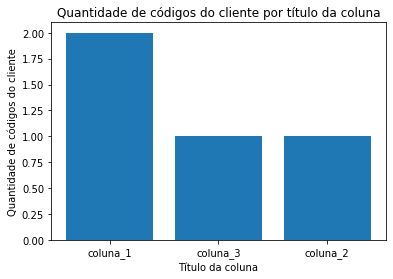

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Crie um dataframe de exemplo
df = pd.DataFrame({'codigo_do_cliente': [1, 2, 3],
                   'coluna_1': [['palavra_1', 'palavra_2'], [], ['palavra_3']],
                   'coluna_2': [[], ['palavra_4'], []],
                   'coluna_3': [['palavra_5'], [], []]})

# Crie uma nova tabela com dois campos código do cliente e o título da coluna que não está vazia na tabela original
new_df = pd.DataFrame(columns=['codigo_do_cliente', 'titulo_da_coluna'])

for index, row in df.iterrows():
    for column in df.columns:
        if column != 'codigo_do_cliente':
            if row[column]:
                new_row = {'codigo_do_cliente': row['codigo_do_cliente'], 'titulo_da_coluna': column}
                new_df = pd.concat([new_df, pd.DataFrame([new_row])])

print(new_df)

# Crie uma visualização com a informação do título_da_coluna e a quantidade de codigos_do_cliente
counts = new_df['titulo_da_coluna'].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Quantidade de códigos do cliente por título da coluna')
plt.xlabel('Título da coluna')
plt.ylabel('Quantidade de códigos do cliente')
plt.show()

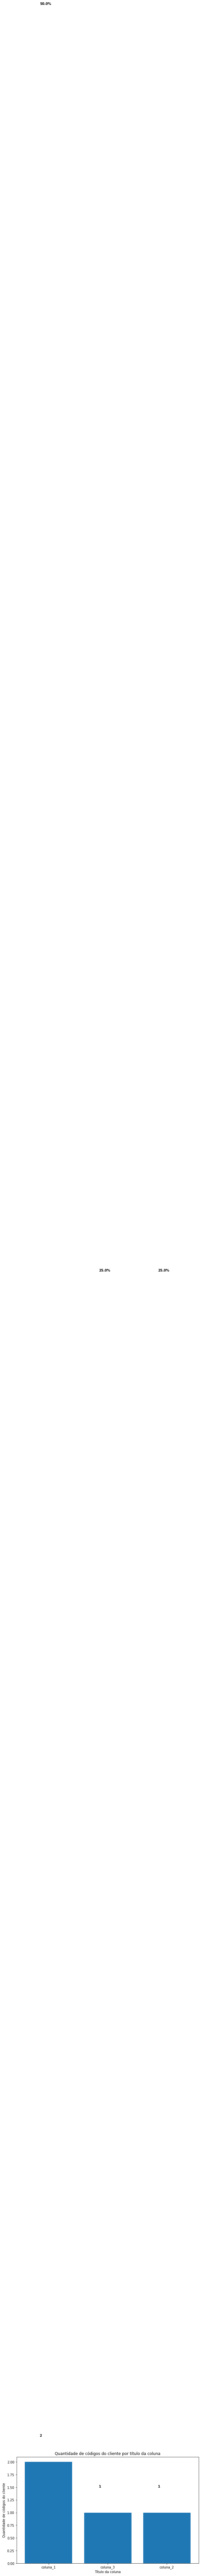

In [6]:
# Crie uma visualização com a informação do título_da_coluna e a quantidade de codigos_do_cliente
counts = new_df['titulo_da_coluna'].value_counts()
total_counts = counts.sum()
percentages = counts / total_counts * 100

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(counts.index, counts.values)
ax.set_title('Quantidade de códigos do cliente por título da coluna')
ax.set_xlabel('Título da coluna')
ax.set_ylabel('Quantidade de códigos do cliente')

for i, v in enumerate(counts.values):
    ax.text(i - 0.15, v + 0.5, str(v), color='black', fontweight='bold')

for i, v in enumerate(percentages.values):
    ax.text(i - 0.15, v + 0.5, str(round(v, 2)) + '%', color='black', fontweight='bold')

plt.show()

In [9]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer

# Baixe o corpus MacMorpho
nltk.download('mac_morpho')

# Crie um dataframe de exemplo
df = pd.DataFrame({'codigo_do_cliente': [1, 2, 3],
                   'conversa_do_cliente': ['Eu estou correndo', 'Ela vai correr', 'Nós tinhamos corrido']})

# Crie uma nova coluna LEMMA com a aplicação do lemmatizador da biblioteca NLTK em lingua portuguesa
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('mac_morpho')
nltk.corpus.mac_morpho.tagged_words()
df['LEMMAS'] = df['conversa_do_cliente'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos='v') for word in nltk.word_tokenize(x)]))

print(df)

   codigo_do_cliente   conversa_do_cliente                LEMMAS
0                  1     Eu estou correndo     Eu estou correndo
1                  2        Ela vai correr        Ela vai correr
2                  3  Nós tinhamos corrido  Nós tinhamos corrido


[nltk_data] Downloading package mac_morpho to
[nltk_data]     C:\Users\vinic\AppData\Roaming\nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vinic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vinic\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vinic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package mac_morpho to
[nltk_data]     C:\Users\vinic\AppData\Roaming\nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!
